In [1]:
#Importing modules

from torchvision import datasets
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import torch
import sys

In [2]:
class CustomDataset():
    def __init__(self, csv_file, img_path):
        #Transforms
        self.resize = transforms.Resize((224,224))
        self.color = transforms.ColorJitter(0.1,0.1,0.1,0.1)
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        #Reading csv File
        self.csv_data = pd.read_csv(csv_file)
        self.img_name_arr = np.asarray(self.csv_data.iloc[:,1]) #2nd column contains names of the images
        self.throttle_label_arr = np.asarray(self.csv_data.iloc[:,3]) #3rd column is Throttle data
        self.steering_label_arr = np.asarray(self.csv_data.iloc[:,4]) #4th column is Steering data
        
        self.label_arr = np.asarray([self.csv_data.iloc[:,3], self.csv_data.iloc[:,4]])
        self.data_length = len(self.csv_data.index)

    def __getitem__(self, index):
        img_name = self.img_name_arr[index] #Getting individual image name
        img = Image.open(img_path + str(img_name)) #Opening image

        #image transformations to tensor
        img_resize = self.resize(img)
        img_color = self.color(img_resize)
        img_tensor = self.to_tensor(img_color)
        img_normalized = self.normalize(img_tensor)

        throttle_label = self.throttle_label_arr[index]
        steering_label = self.steering_label_arr[index]
        img_label = self.label_arr[:,index]
        
        return (img_tensor, img_label)

    def __len__(self):
        return self.data_length

In [3]:
gpu_avail = torch.cuda.is_available()
if(gpu_avail):
    print("GPU is available, training on GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available, training on CPU")
    device = torch.device('cpu')
    

torch.cuda.empty_cache()

GPU is available, training on GPU


In [15]:
#Choose csv file location depending on if we are training on Jetson or Laptop
csv_file = 'C:/Users/Owen/Desktop/Projects/Autonomous RC Car/Data_Collection/Aug9_DataCollection4/Aug9_DataCollection4.csv' 
#csv_file = '/home/dlinano/Desktop/Autonomous-RC-Car-Milestone-2/Data_Collection/Aug6_DataCollection/Aug6_DataCollection.csv'

img_path = 'C:/Users/Owen/Desktop/Projects/Autonomous RC Car/Data_Collection/Aug9_DataCollection4/'

dataset = CustomDataset(csv_file, img_path)
print(dataset.label_arr.shape)
#img, label = dataset.__getitem__(3)
#print(label)

(2, 4527)


In [16]:
#Generate Training and Validation Datsets

batch_size = 64
random_seed = 42 #To ensure indices are always the same when shuffled below
validation_split = 0.2
shuffle_dataset = False

#Creating the data indices for training and validation sets
dataset_size = len(dataset) #Total number of samples
print(dataset_size)
indices = list(range(dataset_size)) 
#print(indices) #Check that correct number of samples
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices) #indices have now been shuffled

training_indices, validation_indices = indices[split:], indices[:split]

#Creating data samplers and loaders
training_sampler = SubsetRandomSampler(training_indices)
validation_sampler = SubsetRandomSampler(validation_indices)

training_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=training_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=validation_sampler)

#len(validation_loader.dataset)
print(len(training_sampler))
print(len(validation_sampler))
print(len(training_loader.dataset)) # length of training sampler / batch_size
print(len(validation_loader.dataset)) #How many batches there in the training loader

4527
3622
905
4527
4527


In [17]:
#PyTorch Neural Network


class Net(nn.Module):
    def __init__(self):
        super().__init__() #Input = 3,224,224
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 5, padding = 2) #112
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 5, padding = 2) #56
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 5, padding = 2) #28
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 3, stride = 2, padding = 1) #7
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7*7*64, 1000)
        self.fc2 = nn.Linear(1000,300)
        self.fc3 = nn.Linear(300,50)
        self.fc4 = nn.Linear(50,2)
        self.dropout = nn.Dropout(0.1)
        
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x))) 
        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x

In [18]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # convolutional layer (sees 224x224x3 image tensor)
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(3, 24, 5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(24, 32, 5, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 5, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64, 50)
        self.fc2 = nn.Linear(50, 2)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #x = self.pool(F.relu(self.conv5(x)))
        # flatten image input
        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [19]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        #conv layer sees 224x224x3 image tensor
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512,50)
        self.fc2 = nn.Linear(50,2)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv4(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv5(x)))
        #print(x.shape)
            
        x = self.flatten(x)
        #print(x.shape)
        x = self.dropout(x)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = self.dropout(x)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        
        return x

In [20]:
tb = SummaryWriter('runs/Autonomous_RC_Car_Training_1')

network =CNN1() #Create instance of network
images, labels = next(iter(training_loader))
grid = torchvision.utils.make_grid(images)

tb.add_image('Track Images', grid)
tb.add_graph(network, images)
tb.close()


In [21]:
def get_num_correct(outputs, labels):
    return outputs.argmax(dim=1).eq(labels).sum().item()

In [28]:
#Training

import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    training_loss_min = np.Inf
    for epoch in range(1, n_epochs + 1):
        training_loss = 0.0
        total_correct = 0.0
        validation_loss = 0.0
        
        model.train() #Training the model
        for imgs, labels in train_loader:
            if torch.cuda.is_available():
                imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels.float())
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            training_loss += loss.item()
            #total_correct += get_num_correct(outputs, labels)
        '''
        model.eval() #Evaluating the model
        for imgs, labels in validation_loader:
            if torch.cuda.is_available():
                imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels.float())
            validation_loss += loss.item()
        '''    
        training_loss = training_loss / len(train_loader)   
        #validation_loss = validation_loss / len(validation_loss)
        #print(training_loss)
        print('{} Epoch {}, Training Loss {}'.format(datetime.datetime.now(), epoch, 
                                                        training_loss))
              
        if training_loss <= training_loss_min:
            print('Training loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            training_loss_min,
            training_loss))
            torch.save(model.state_dict(), 'Autonomous_RC_Car_Net2_5.pt')
            training_loss_min = training_loss
            
        tb.add_scalar('Loss', training_loss, epoch)
        
        #tb.add_histogram('conv1.bias', model.conv1.bias, epoch)
        #tb.add_histogram('conv1.weight', model.conv1.weight, epoch)
        #tb.add_histogram('conv1.weight.grad',network.conv1.weight.grad,epoch)


In [29]:
#Validation

def validation_loop(n_epochs, model, loss_fn, validation_loader):
    validation_loss_min = np.Inf
    with torch.no_grad():
        for epoch in range(1, n_epochs+1):
            validation_loss = 0.0

            model.eval()
            for imgs, labels in validation_loader:
                if torch.cuda.is_available():
                    imgs, labels = imgs.cuda(), labels.cuda()
                outputs = model(imgs)
                loss = loss_fn(outputs, labels.float())
                validation_loss += loss.item()

            print('Validaiton Loss: {}'.format(validation_loss / len(validation_loader)))

In [30]:
model = Net2()

optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

validation_loss_min = np.Inf
training_loss_min = np.Inf
if gpu_avail:
    model.cuda()

In [31]:
#Call Training Loop

training_loop(
            n_epochs = 15,
            optimizer = optimizer,
            model = model,
            loss_fn = loss_fn,
            train_loader = training_loader)



2020-08-11 23:09:07.348827 Epoch 1, Training Loss 0.14298325855480998
Training loss decreased (inf --> 0.142983).  Saving model ...
2020-08-11 23:10:03.882783 Epoch 2, Training Loss 0.03187195946903605
Training loss decreased (0.142983 --> 0.031872).  Saving model ...
2020-08-11 23:10:57.787581 Epoch 3, Training Loss 0.022637145691796354
Training loss decreased (0.031872 --> 0.022637).  Saving model ...
2020-08-11 23:11:50.900912 Epoch 4, Training Loss 0.01436972299492673
Training loss decreased (0.022637 --> 0.014370).  Saving model ...
2020-08-11 23:12:49.498600 Epoch 5, Training Loss 0.01109750531287047
Training loss decreased (0.014370 --> 0.011098).  Saving model ...
2020-08-11 23:13:45.085635 Epoch 6, Training Loss 0.00932532520311182
Training loss decreased (0.011098 --> 0.009325).  Saving model ...
2020-08-11 23:14:52.482854 Epoch 7, Training Loss 0.008595341832883525
Training loss decreased (0.009325 --> 0.008595).  Saving model ...
2020-08-11 23:16:10.338839 Epoch 8, Training

In [10]:
torch.cuda.empty_cache()
#Load Model
model.load_state_dict(torch.load('Autonomous_RC_Car2.pt'))

<All keys matched successfully>

In [ ]:
validation_loop(n_epochs = 10,
            model = model,
            loss_fn = loss_fn,
            validation_loader = validation_loader)

In [ ]:
#Load Model
model.load_state_dict(torch.load('Autonomous_RC_Car2.pt'))

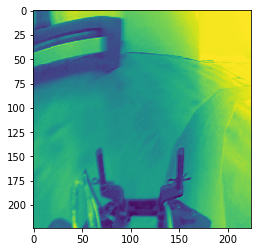

(3, 224, 224)

In [21]:
#Testing
single_image_name = img_path + 'Aug9_DataCollection_432.jpg'

img_as_img = Image.open(str(single_image_name))

resize = transforms.Resize((224,224))
#self.center = transforms.CenterCrop(224)
color = transforms.ColorJitter(0.1, 0.1, 0.1, 0.1)
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Transform image to tensor
img_resize = resize(img_as_img)
img_color = color(img_resize)
img_as_tensor = to_tensor(img_color)
img_normalized = normalize(img_as_tensor)
img_normalized.shape

plt.imshow(img_normalized[0], interpolation='nearest')
plt.show()

test = np.append(img_as_tensor,[])
test = test.reshape(3,224,224)
test.shape



In [22]:
device = torch.device('cuda')
test = torch.from_numpy(test)
test = test.to(device)
test = test.float()
print(test.shape)
test = test.unsqueeze(0)
output = model(test)
print(output)

torch.Size([3, 224, 224])
tensor([[0.5973, 0.7309]], device='cuda:0', grad_fn=<AddmmBackward>)
